In [1]:
import os,sys
from google.colab import drive
drive.mount('/content/gdrive')
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/gdrive


In [1]:
!pwd

/content


In [2]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab"


/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab


In [3]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab


In [ ]:
!git clone https://github.com/zzh8829/yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 439 (delta 2), reused 0 (delta 0), pack-reused 433
Receiving objects: 100% (439/439), 4.24 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [4]:
%cd yolov3-tf2/
!pwd

/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab/yolov3-tf2
/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab/yolov3-tf2


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/gdrive/MyDrive/Colab%20Notebooks/YOLO-Object-Detection-colab/yolov3-tf2 (from -r requirements.txt (line 6))
  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


In [ ]:
!pip install -r requirements-gpu.txt
!pip install keras==2.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/gdrive/My%20Drive/Colab%20Notebooks/YOLO-Object-Detection-colab/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 모델 파일 변환

DarkNet의 모델파일을 Keras에서 사용할 수 있는 모델 파일로 변환
- `convert.py`: 변환 실행 파일
- `yolov3.weight`: Darknet으로 학습된 모델 파일
- `yolov3.tf`: Keras Yolov3 모델


* Yolov3 Weight: https://pjreddie.com/media/files/yolov3.weights

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
# -O filename DOWNLOAD-URL : wget을 통해 다운로드 할 경우 저장되는 파일명은 URL의 마지막 '/' 뒤에 오는 단어를 파일명으로 저장한다.

--2022-05-27 13:50:21--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  17.9MB/s    in 14s     

2022-05-27 13:50:36 (16.4 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]



In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [7]:
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

### Detector

In [6]:
import time 
import cv2
import numpy as np
import tensorflow as tf

from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
from absl import app, logging, flags
from absl.flags import FLAGS

from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Image, display


In [7]:
flags.DEFINE_string('classes', './data/coco.names', 'classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf', 'weights file') 
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size',416,'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'input image')
flags.DEFINE_string('tfrecord',None,'tfrecord')
flags.DEFINE_string('output', './output.jpg', 'output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [8]:
yolo = YoloV3(classes=FLAGS.num_classes)
yolo.load_weights(FLAGS.weights).expect_partial()
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]

In [9]:
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
def detector():
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  print('time: {}'.format(t2-t1)) 

  for i in range(nums[0]):
    print('{},{},{}'.format(class_names[int(classes[0][i])],
                            np.array(scores[0][i]),
                            np.array(boxes[0][i])))
    
  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  return img

In [11]:
!ls data

checkpoint  girl.png	meme.jpg      street.jpg      voc2012.names
coco.names  meme2.jpeg	meme_out.jpg  street_out.jpg  yolov3.weights


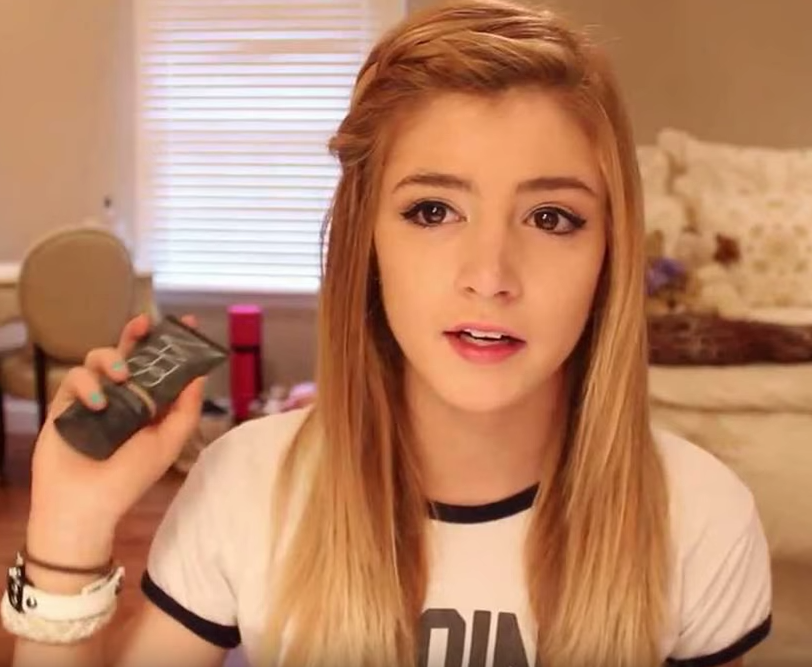

In [12]:
FLAGS.image = 'data/girl.png'
Image(filename=FLAGS.image, width=500)

time: 2.863860607147217
person,0.9997697472572327,[0.06754473 0.03718689 0.967988   0.9650755 ]
chair,0.9255481958389282,[0.01851871 0.34200278 0.17385134 0.6278329 ]


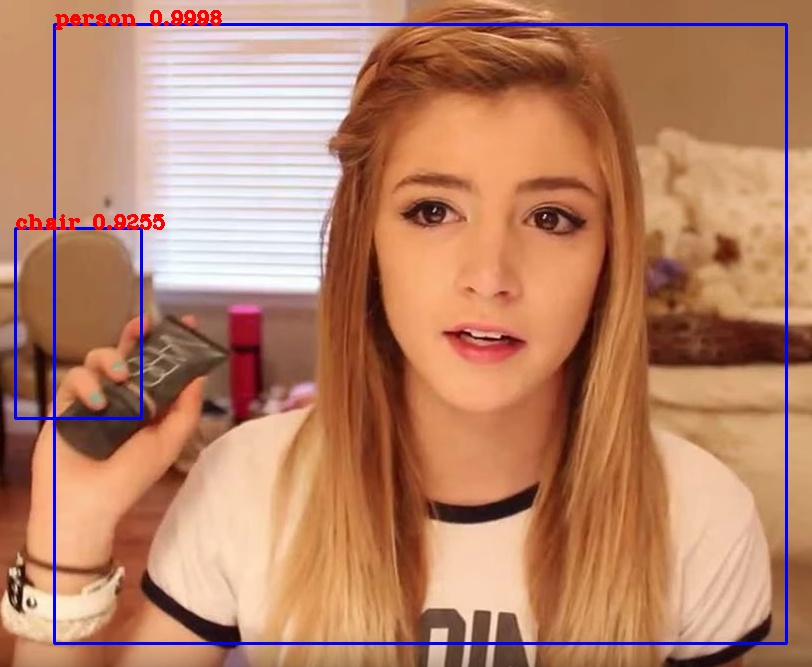

In [13]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=500))

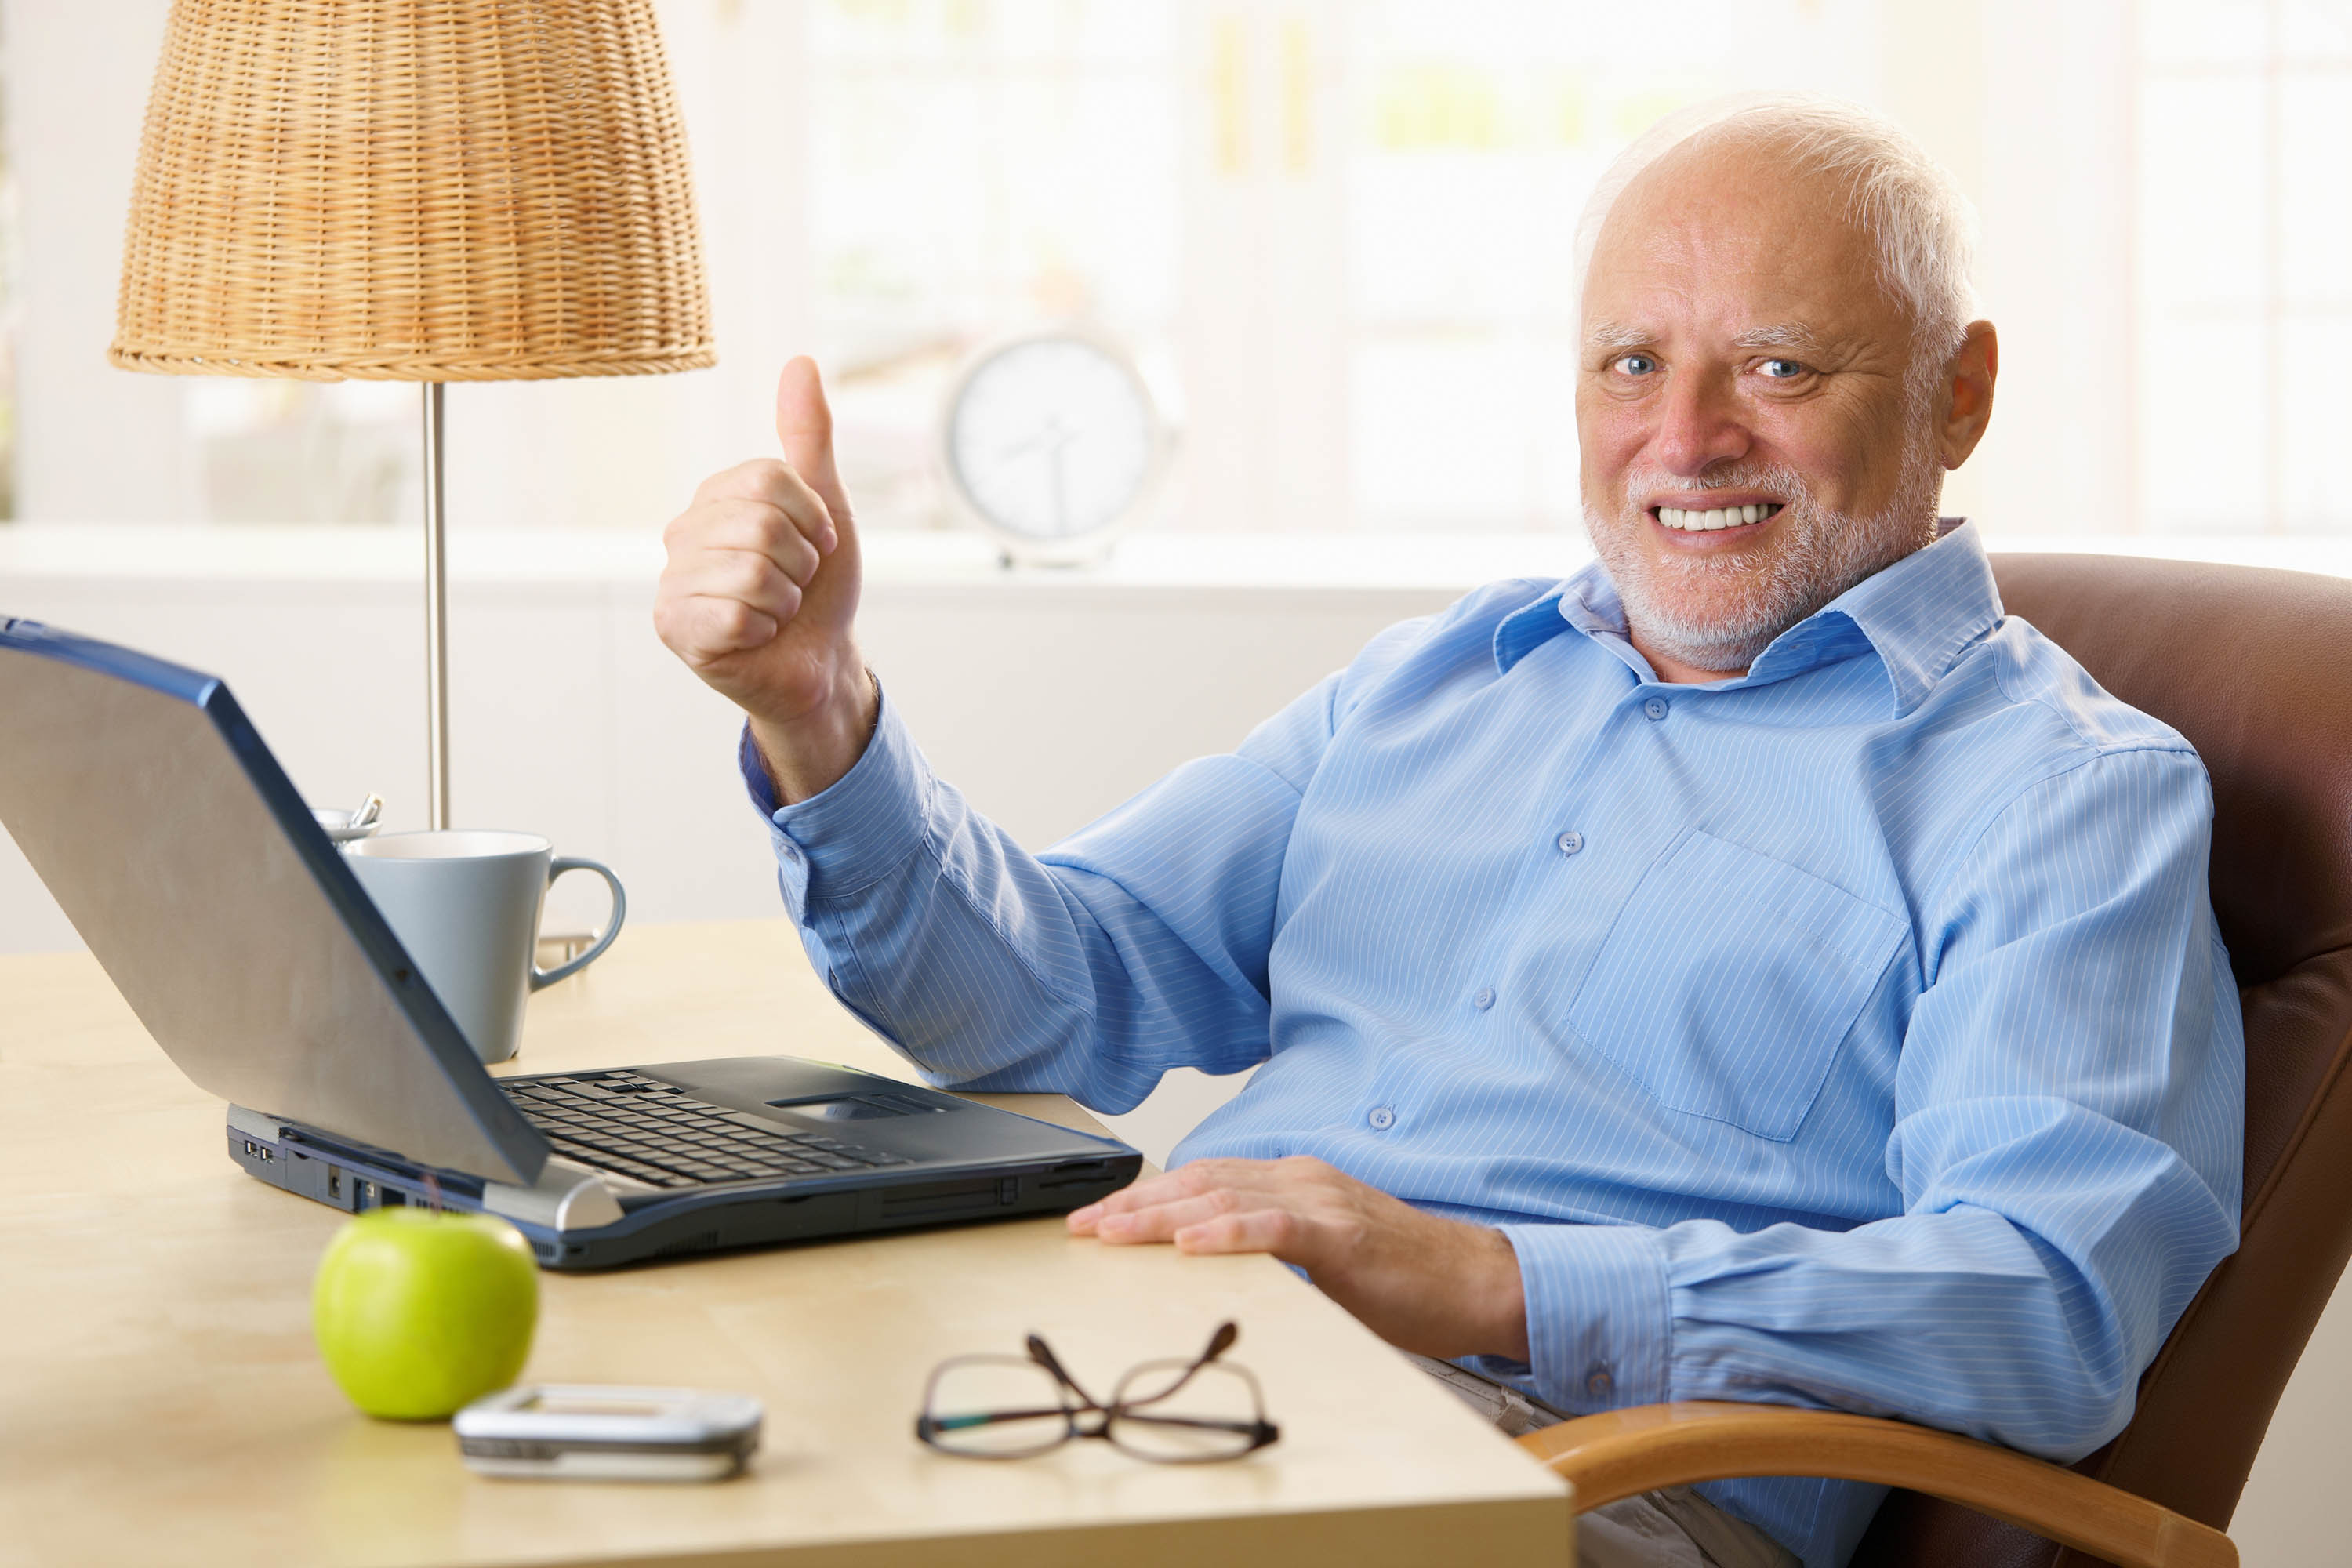

In [14]:
FLAGS.image = 'data/meme.jpg'
Image(filename=FLAGS.image, width=1000)

time: 0.11365818977355957
cup,0.9980731010437012,[0.14266218 0.52777606 0.27184254 0.65748256]
person,0.9976975321769714,[0.2898292 0.0985465 0.9584648 0.9202168]
laptop,0.9599869847297668,[-0.01710659  0.39493692  0.5229728   0.7962775 ]
apple,0.9081627726554871,[0.13114461 0.77143586 0.22893354 0.90729535]
cell phone,0.7321376204490662,[0.18850097 0.87569416 0.3350185  0.9422209 ]
clock,0.6700009703636169,[0.4010809  0.21244612 0.49267417 0.35021505]
cup,0.5366388559341431,[0.1508823  0.52855617 0.25541586 0.66439587]
chair,0.5001124739646912,[0.29507312 0.30677184 0.99988604 0.9955944 ]


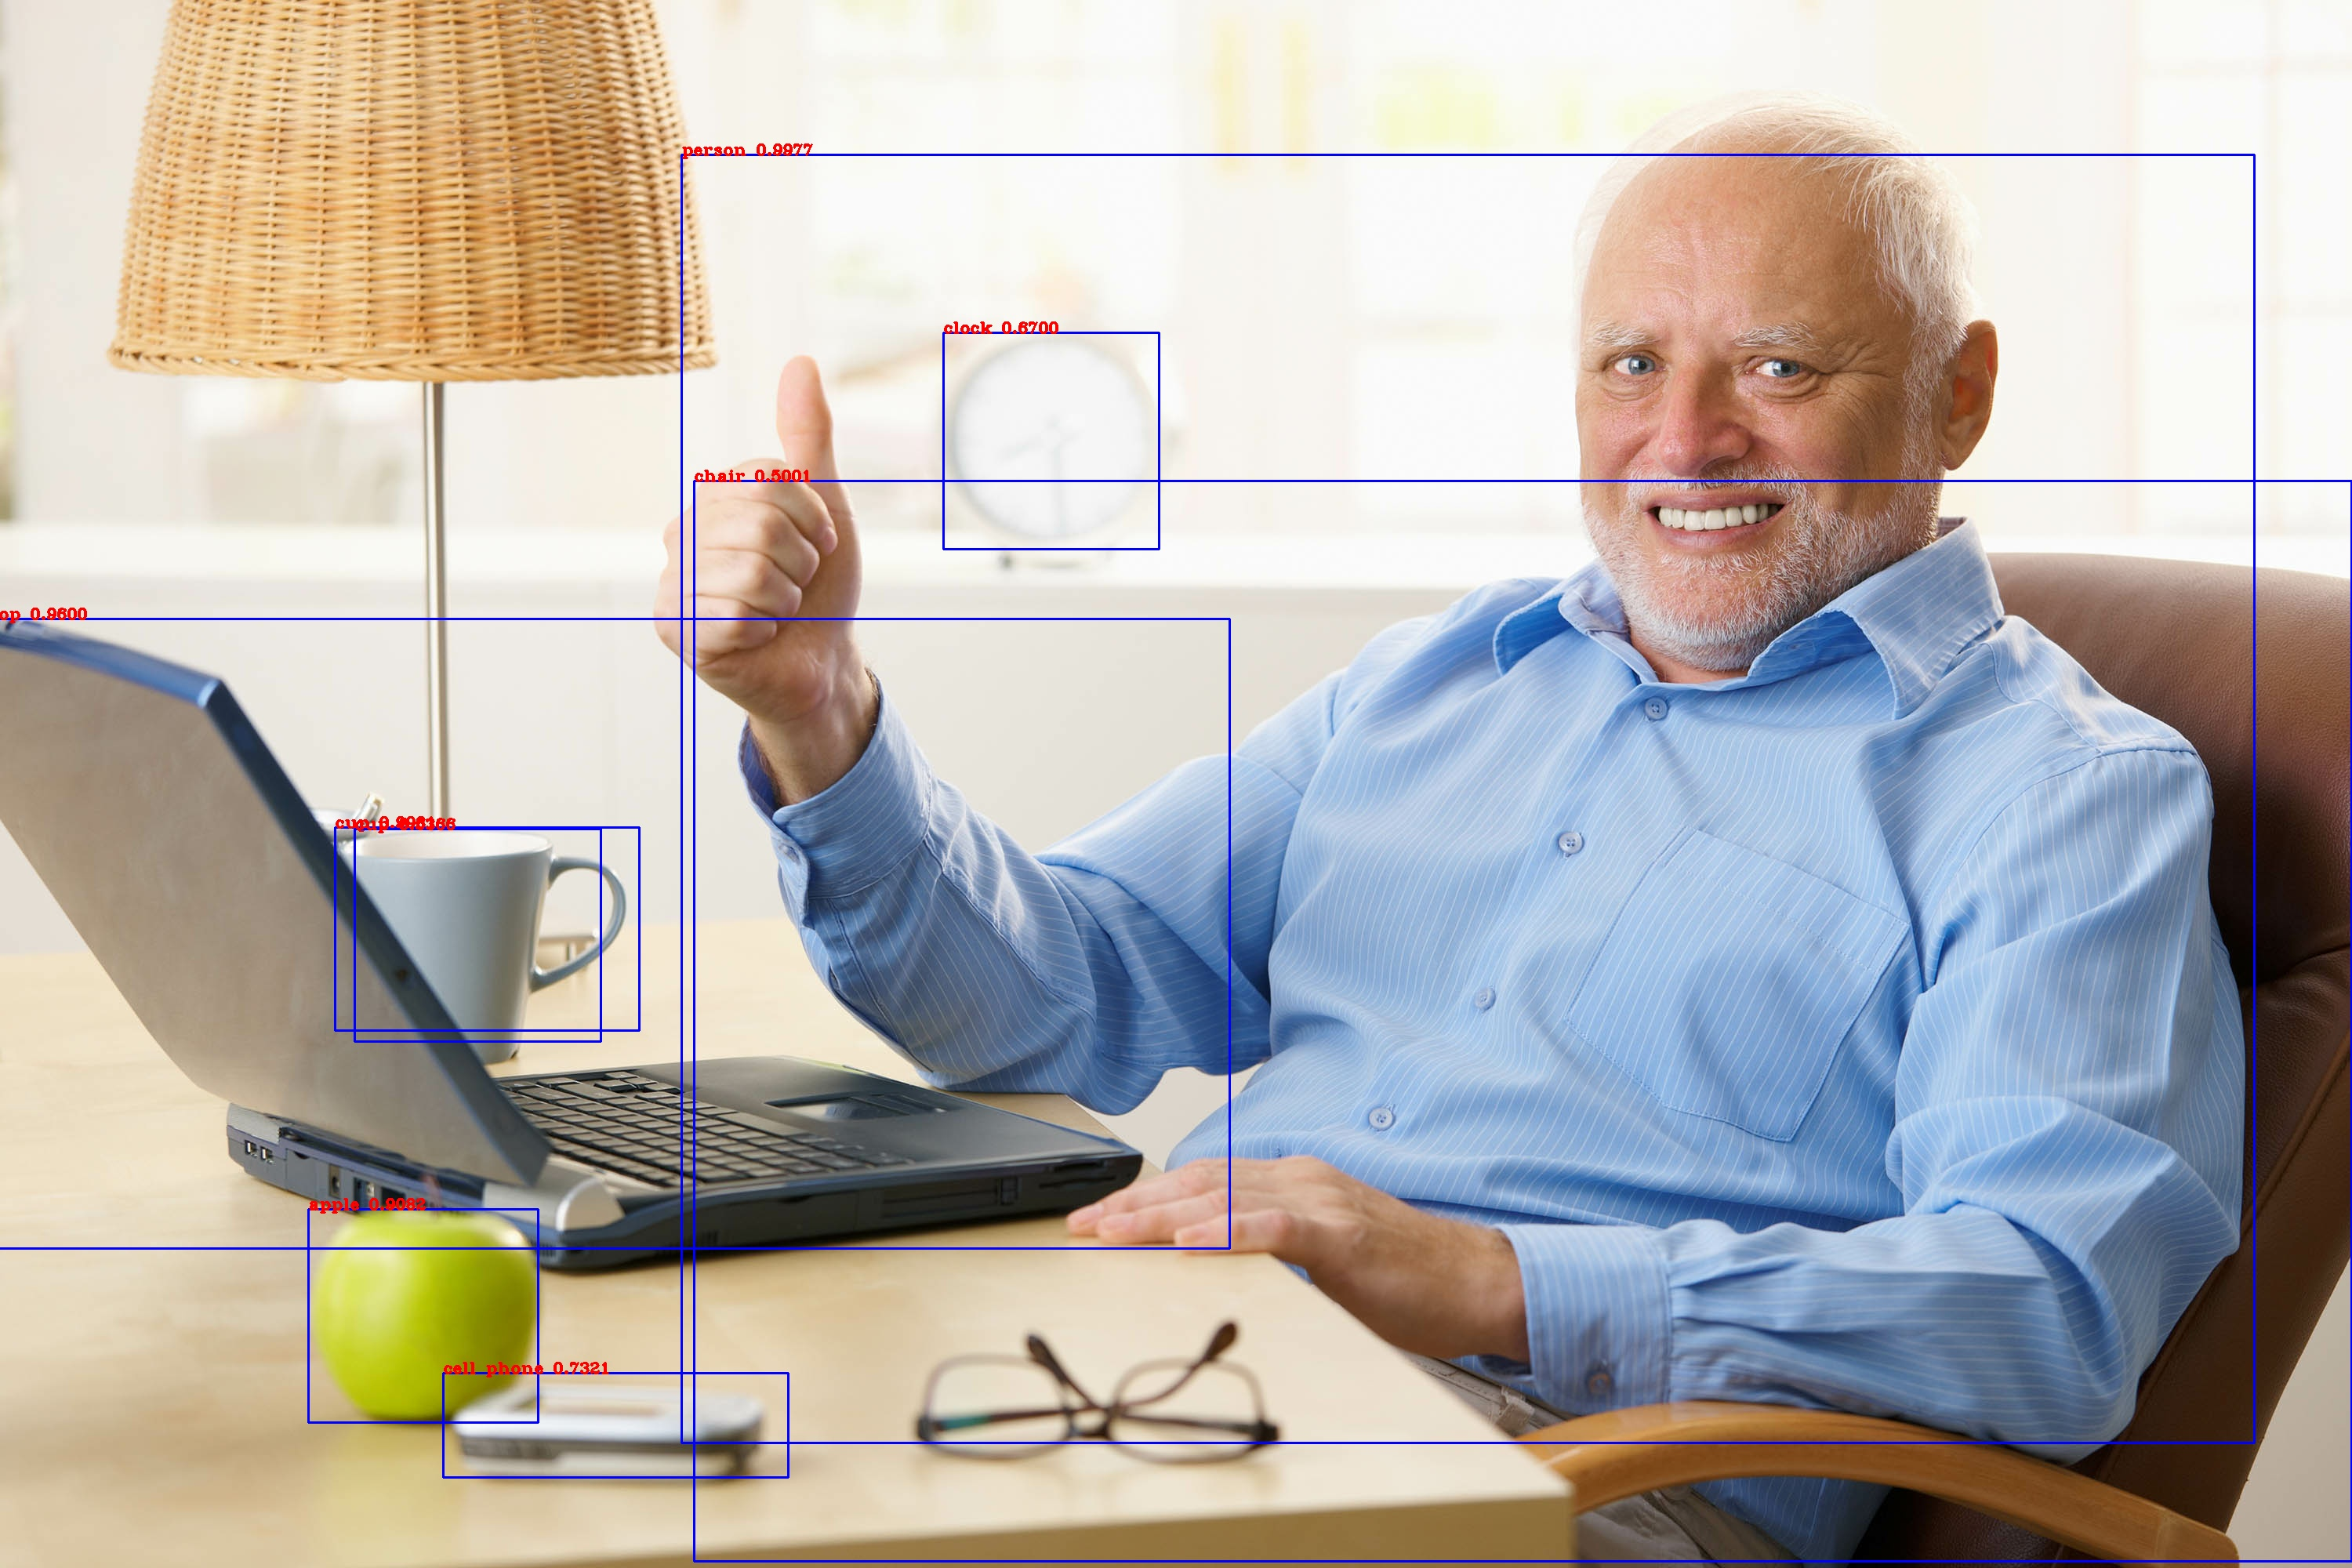

In [15]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=1000))

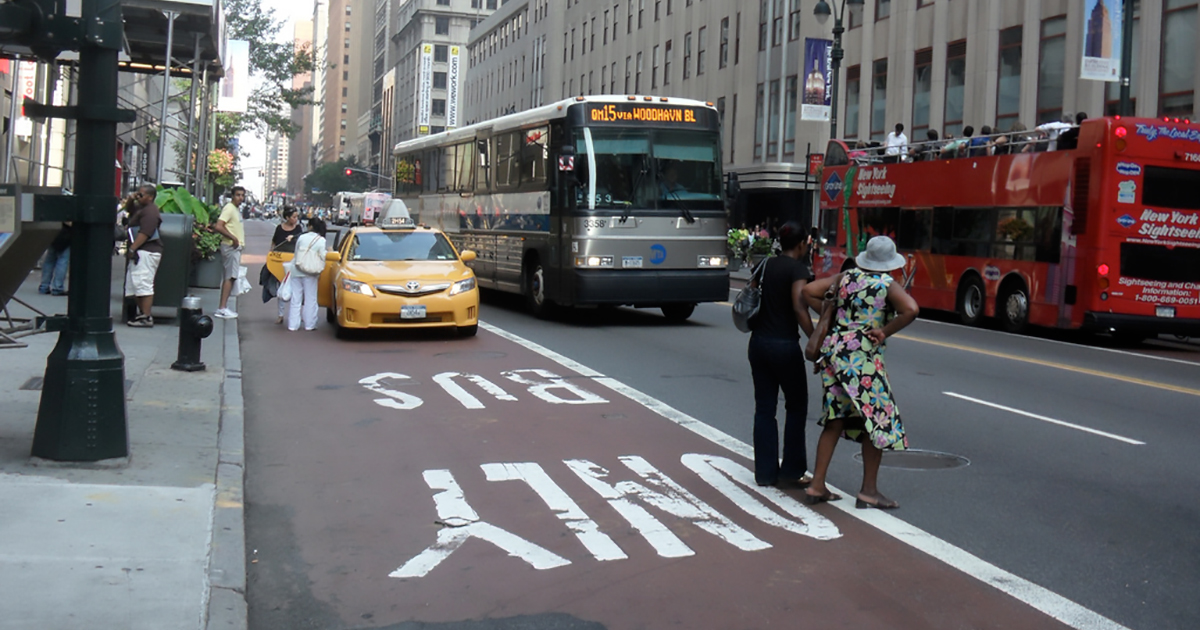

In [16]:
FLAGS.image = 'data/street.jpg'
Image(filename=FLAGS.image, width=800)

time: 0.10965442657470703
car,0.9966800212860107,[0.26270664 0.3466965  0.40587908 0.54019135]
bus,0.9951198101043701,[0.67014587 0.17855003 0.9937171  0.5290146 ]
person,0.9870266914367676,[0.6138846 0.3450544 0.6877058 0.7753   ]
bus,0.9826598763465881,[0.3228875  0.15145977 0.6138201  0.506682  ]
person,0.9748104810714722,[0.22922696 0.34322935 0.26619264 0.52385163]
person,0.9731234908103943,[0.10603386 0.29673994 0.14109921 0.52050036]
person,0.9698238372802734,[0.6745359  0.36693054 0.76731586 0.80656105]
person,0.840420126914978,[0.73152274 0.19712627 0.76029474 0.2559415 ]
person,0.7661860585212708,[0.14938344 0.30133063 0.20066254 0.5780297 ]
person,0.6201274394989014,[0.8069899  0.19955894 0.82683456 0.24689198]
traffic light,0.5584408044815063,[0.2863981  0.26624355 0.29791862 0.28726056]
bus,0.5482759475708008,[0.27228153 0.10793351 0.62918967 0.4942211 ]
person,0.5450268983840942,[0.6202499  0.34034783 0.7012078  0.7859604 ]
person,0.5271654725074768,[0.22365157 0.32688165

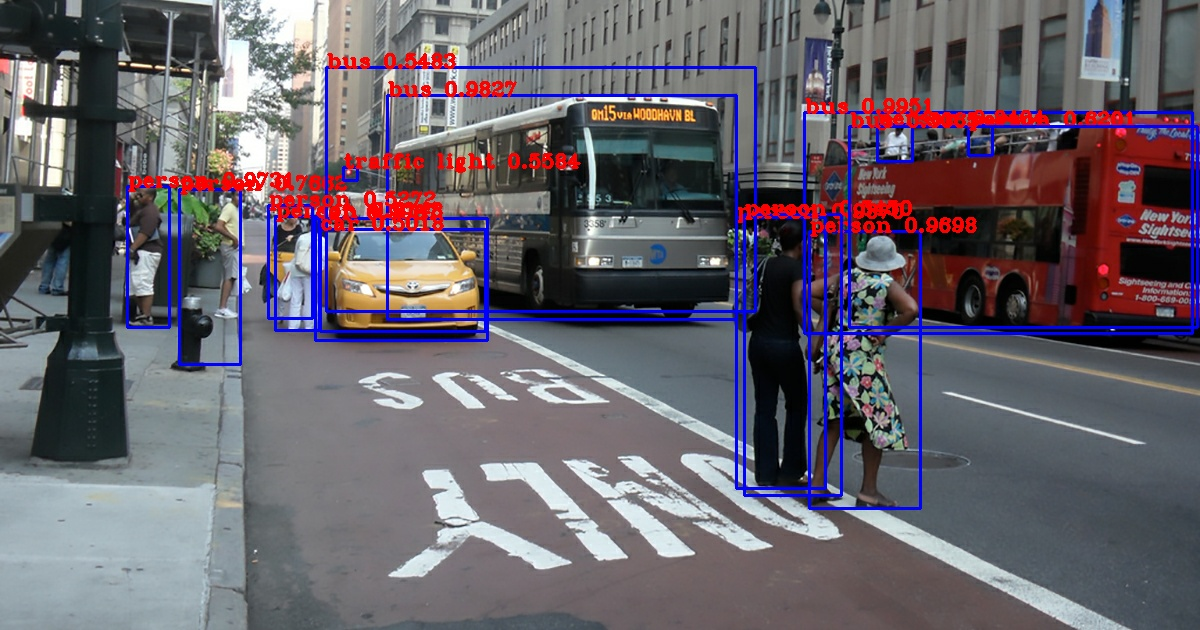

In [17]:
output = detector()
display(Image(data=bytes(cv2.imencode('.jpg', output)[1]), width=800))

## YOLOv3 모델 (PyTorch)

* https://github.com/ultralytics/yolov3
* https://www.ultralytics.com

### 모델 다운로드

In [18]:
!git clone https://github.com/ultralytics/yolov3

Cloning into 'yolov3'...
remote: Enumerating objects: 10012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10012 (delta 3), reused 5 (delta 1), pack-reused 10002
Receiving objects: 100% (10012/10012), 9.33 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (6750/6750), done.


In [24]:
%cd yolov3

/content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab/yolov3-tf2/yolov3


In [25]:
%pip install -qr requirements.txt

In [26]:
import yaml
import torch
from IPython.display import Image, clear_output

print(f"Torch: {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
 

Torch: 1.11.0+cu113 (Tesla T4)


### 추론(Inference)

`detect.py`: YOLOv3 모델을 이용한 추론

In [28]:
!ls data/images

bus.jpg  zidane.jpg


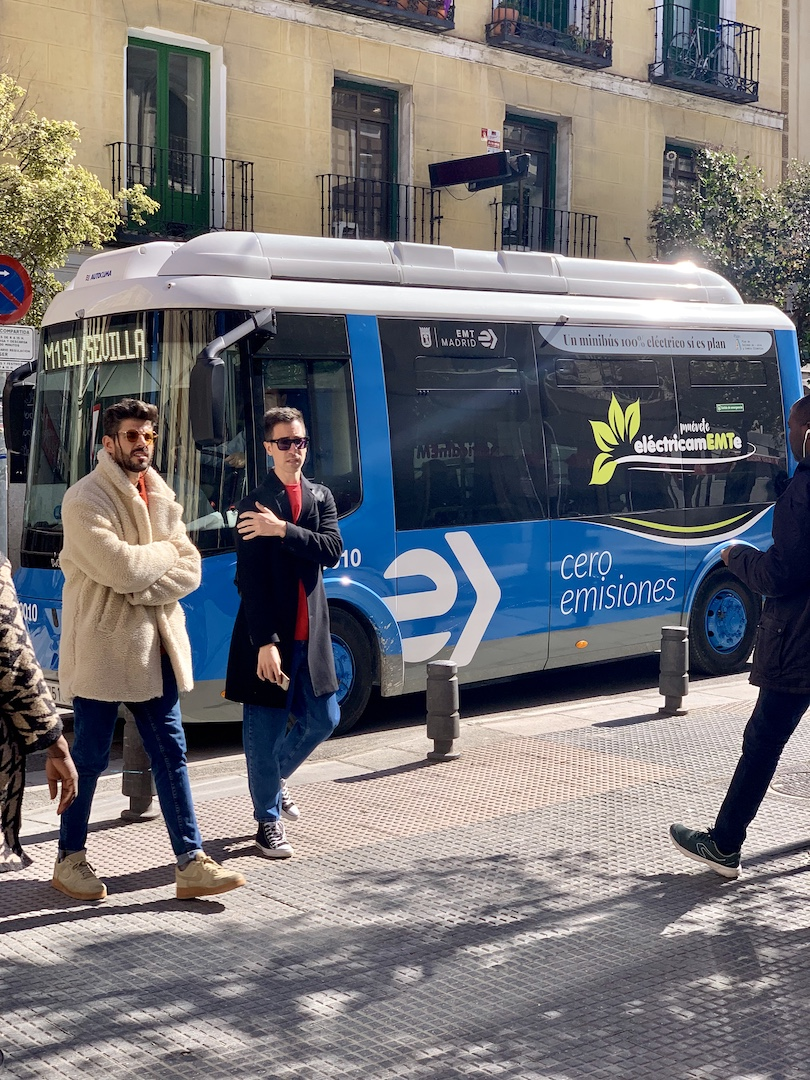

In [29]:
Image(filename='data/images/bus.jpg', width=600)

In [30]:
!python detect.py --weights yolov3.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov3.pt'], source=data/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 2022-5-27 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 119M/119M [00:13<00:00, 9.17MB/s]

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients
image 1/2 /content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab/yolov3-tf2/yolov3/data/images/bus.jpg: 640x480 4 persons, 1 bicycle, 1 bus, Done. (0.052s)
image 2/2 /content/gdrive/MyDrive/Colab Notebooks/YOLO-Object-Detection-colab/yolov3-tf2/yolov3/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.046s)
Speed: 2.1ms pre-process, 49.0ms inference, 24.1ms NMS per image at shape (

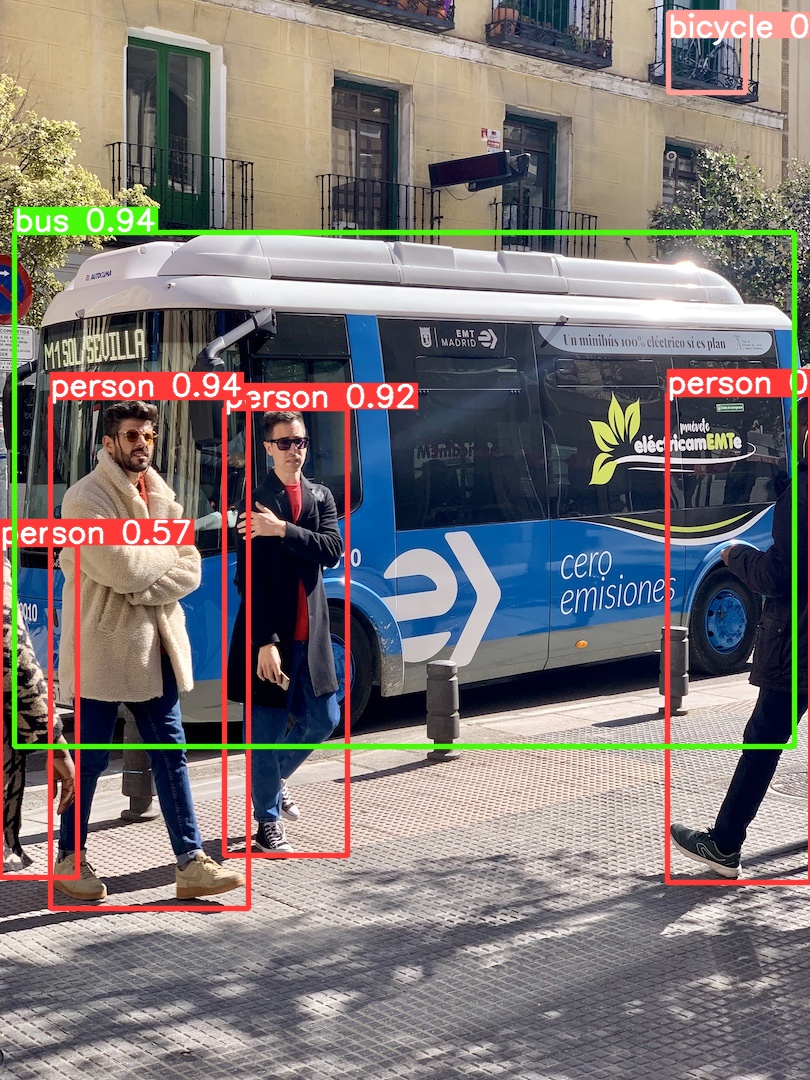

In [33]:
Image(filename='runs/detect/exp/bus.jpg', width=600)

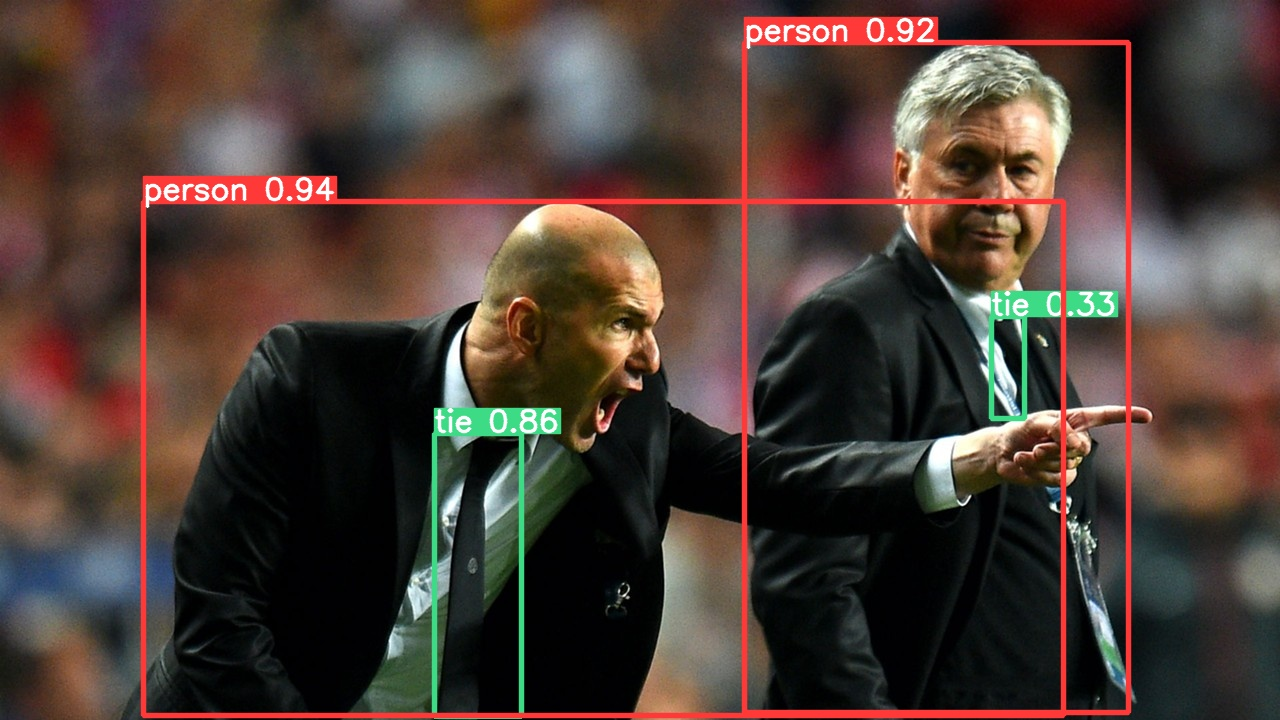

In [34]:
Image(filename='runs/detect/exp/zidane.jpg', width=600)

## YOLOv5 모델 (PyTorch)

* https://github.com/ultralytics/yolov5
* https://www.ultralytics.com

### 모델 다운로드